In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data_path = 'data/BTC_with_Reddit_1min.csv'
data = pd.read_csv(data_path).drop(['time_period_start', 'time_period_end'], axis=1)
data.head()

,price_open,price_high,price_low,price_close,volume_traded,reddit_sentiment,pos_keywords_occur,neg_keywords_occur
0,38320.00,38417.80,38319.99,38394.98,92.019354,0.0,0,0
1,38381.19,38381.19,38230.81,38257.69,3.200295,0.0,0,0
2,38251.68,38361.29,38247.05,38361.29,3.536984,0.0,0,0
3,38375.70,38485.00,38375.70,38455.46,9.787897,0.0,0,0
4,38446.95,38556.27,38446.95,38556.27,30.134611,0.0,0,0


In [3]:
data_features = data.drop(['price_close'], axis=1)
data_labels = data['price_close']

# data = data.to_numpy()

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))

train_size1 = int(0.7 * len(label))
train_size2 = int(0.9 * len(label))

In [4]:
def split_data(f, l, delay):
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

X_train2_GRU, y_train2_GRU = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], 60)
X_train2_LSTM, y_train2_LSTM = split_data(feature[train_size1:train_size2], label[train_size1:train_size2], 1)
X_test_GRU, y_test_GRU = split_data(feature[train_size2:], label[train_size2:], 60)
X_test_LSTM, y_test_LSTM = split_data(feature[train_size2:], label[train_size2:], 1)

In [5]:
GRU = [tf.keras.models.load_model('./meta_data/gru'+str(i)+'.h5') for i in range(5)]
LSTM = [tf.keras.models.load_model('./meta_data/LSTM'+str(i)+'.h5') for i in range(5)]

2022-09-07 09:29:40.873698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:29:40.881925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:29:40.882158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 09:29:40.882977: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [35]:
pred_GRU = [model.predict(X_train2_GRU) for model in GRU]
pred_LSTM = [model.predict(X_train2_LSTM) for model in LSTM]

In [36]:
print(np.array(pred_GRU).shape)
print(np.array(pred_LSTM).shape)

(5, 108804, 1)
(5, 108863, 1)


In [37]:
pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

print(pred_LSTM[:, 59:, :].shape)
tmp = np.concatenate((pred_GRU, pred_LSTM[:, 59:, :]), axis=0)
print(tmp.shape)
print(y_train2_GRU.shape)

tmp = np.squeeze(tmp, axis=2).transpose()


(5, 108804, 1)
(10, 108804, 1)
(108804,)


In [66]:
pred_GRU = [model.predict(X_test_GRU) for model in GRU]
pred_LSTM = [model.predict(X_test_LSTM) for model in LSTM]

pred_LSTM = np.array(pred_LSTM)
pred_GRU = np.array(pred_GRU)

print(pred_LSTM[:, 59:, :].shape)
tmp2 = np.concatenate((pred_GRU, pred_LSTM[:, 59:, :]), axis=0)
# print(tmp.shape)
# print(y_train2_GRU.shape)

tmp2 = np.squeeze(tmp2, axis=2).transpose()



(5, 54372, 1)


In [94]:
from keras.layers import Dropout
from keras.engine.sequential import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD
batch_size = 64
model = Sequential([
                    Dense(1)
                    # Activation('relu')
                    # Dropout(0.2)
                    ])

model.compile(optimizer= Adam(learning_rate=5e-5), loss='mse', metrics=['accuracy'])
print(y_train2_GRU.shape)
print(tmp.shape)
model.fit(tmp, y_train2_GRU, batch_size = batch_size, epochs=10, verbose = 1)

# model.predict()


(108804,)
(108804, 10)
Epoch 1/10
1701/1701 [==============================] - 1s 767us/step - loss: 0.4545 - accuracy: 0.0000e+00
Epoch 2/10
1701/1701 [==============================] - 1s 709us/step - loss: 0.0627 - accuracy: 0.0000e+00
Epoch 3/10
1701/1701 [==============================] - 1s 714us/step - loss: 0.0029 - accuracy: 9.1908e-06
Epoch 4/10
1701/1701 [==============================] - 1s 723us/step - loss: 0.0011 - accuracy: 9.1908e-06
Epoch 5/10
1701/1701 [==============================] - 1s 711us/step - loss: 8.7372e-04 - accuracy: 9.1908e-06
Epoch 6/10
1701/1701 [==============================] - 1s 720us/step - loss: 5.3362e-04 - accuracy: 9.1908e-06
Epoch 7/10
1701/1701 [==============================] - 1s 714us/step - loss: 1.9732e-04 - accuracy: 9.1908e-06
Epoch 8/10
1701/1701 [==============================] - 1s 709us/step - loss: 2.9989e-05 - accuracy: 9.1908e-06
Epoch 9/10
1701/1701 [==============================] - 1s 712us/step - loss: 1.2961e-06 - accura

(54372, 1)


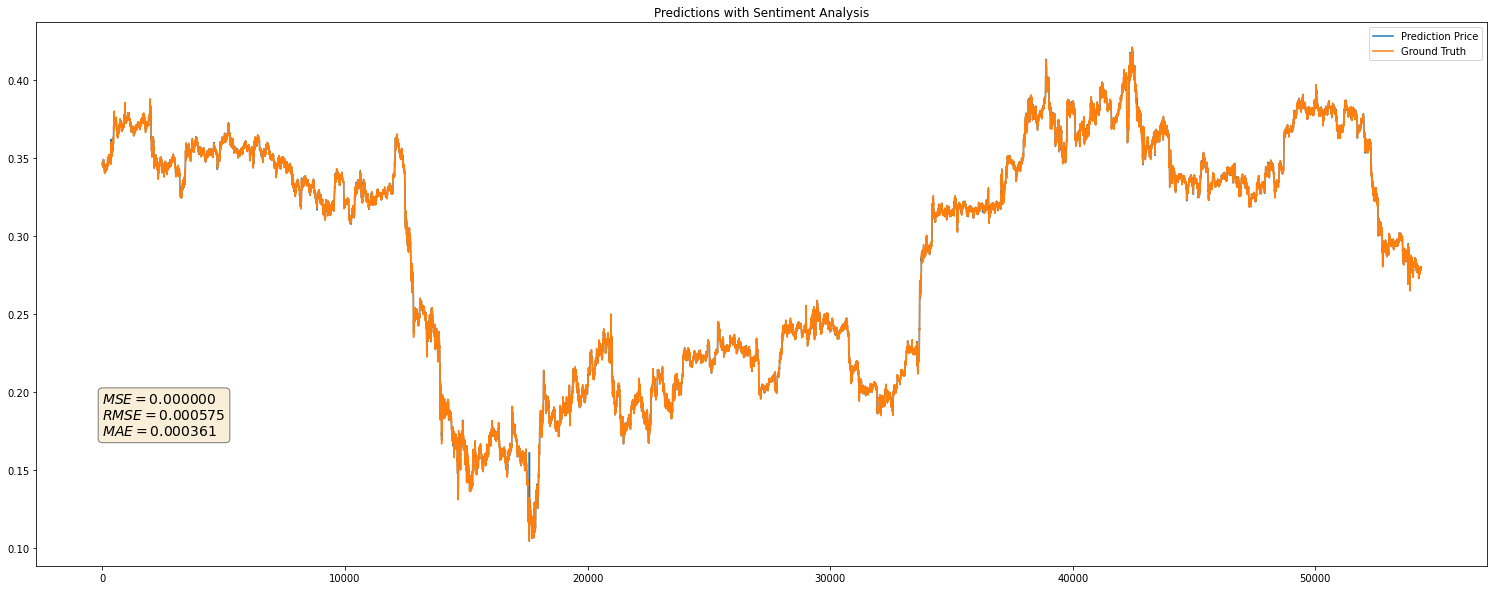

In [95]:
prediction = model.predict(tmp2)
print(prediction.shape)
mse = mean_squared_error(y_test_GRU, prediction)
rmse = mean_squared_error(y_test_GRU, prediction, squared=False)
mae = mean_absolute_error(y_test_GRU, prediction)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(prediction, label='Prediction Price')
plt.plot(y_test_GRU, label='Ground Truth')
plt.legend()
plt.title('Predictions with Sentiment Analysis')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.1, 0.2, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

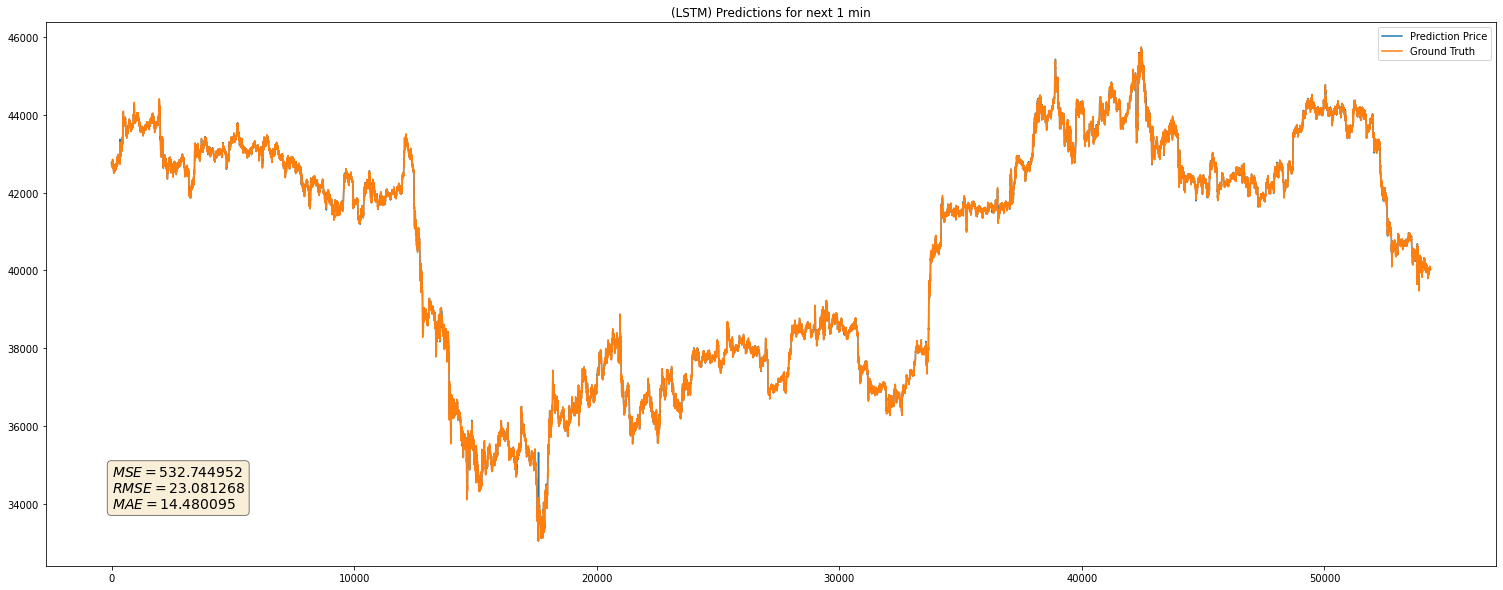

In [96]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test_GRU.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('(LSTM) Predictions for next 1 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 35000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()